In [ ]:
!git clone https://github.com/WouterBant/GEVit-DL2-Project.git

In [6]:
!ls

Train_MNIST.ipynb	     post_hoc_equivariance.ipynb
challenge.ipynb		     results
checkpoints		     steerability_artifact.ipynb
create_rotation_video.ipynb  train_ViT.ipynb
demo_only_3_and_8.ipynb      visualise_rotate.ipynb
plot_result.ipynb


In [5]:
%cd GEVit-DL2-Project/src/post_hoc_equivariance

[Errno 2] No such file or directory: 'post_hoc_equivariance'
/home/wouter/thisistheone/GEVit-DL2-Project/demos


In [22]:
%load_ext autoreload
%autoreload 2

In [12]:
!pip install einops
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 9.7 MB/s eta 0:00:00:00:0100:01
Using cached click-8.1.7-py3-none-any.whl (97 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.1/281.1 kB 9.1 MB/s eta 0:00:00
Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
Using cached smmap-5.0.1-py3-none-any.whl (24 kB)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvtf
import torchvision.transforms.functional as TF

import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from datasets import MNIST_rot
from train_vit import VisionTransformer

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using CUDA
    torch.backends.cudnn.deterministic = True  # if using CUDA
    torch.backends.cudnn.benchmark = False  # if using CUDA, may improve performance but can lead to non-reproducible results

def get_non_equivariant_vit():
    model = VisionTransformer(embed_dim=64,
                            hidden_dim=512,
                            num_heads=4,
                            num_layers=6,
                            patch_size=4,
                            num_channels=1,
                            num_patches=49,
                            num_classes=10,
                            dropout=0.1).to(device)
    model_path = "checkpoints/model2.pt"
    print(model.load_state_dict(torch.load(model_path, map_location=device), strict=False))
    return model

model = get_non_equivariant_vit()

<All keys matched successfully>


In [17]:
data_mean = (0.1307,)
data_stddev = (0.3081,)

transform_train = tvtf.Compose([
    tvtf.RandomRotation(degrees=(-180, 180)),  # random rotation
    tvtf.RandomHorizontalFlip(),  # random horizontal flip with a probability of 0.5
    tvtf.RandomVerticalFlip(),
    tvtf.ToTensor(),
    tvtf.Normalize(data_mean, data_stddev)
])
transform_test = tvtf.Compose(
    [
        tvtf.ToTensor(),
        tvtf.Normalize(data_mean, data_stddev),
    ]
)

train_set = MNIST_rot(root="../data", stage="train", download=True, transform=transform_train, data_fraction=1, only_3_and_8=False)
validation_set = MNIST_rot(root="../data", stage="validation", download=True, transform=transform_test, data_fraction=1, only_3_and_8=False)
test_set = MNIST_rot(root="../data", stage="test", download=True, transform=transform_test, data_fraction=1, only_3_and_8=False)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
)
val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=128,
    shuffle=True,
    num_workers=4,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
)
img_loader = torch.utils.data.DataLoader(  # single element for visualization purposes
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=4,
)

100%|██████████| 58424278/58424278 [00:07<00:00, 7481416.32it/s] 


Extracting ../data/MNIST_rot/raw/mnist_rotation_new.zip to ../data/MNIST_rot/raw
Processing...
Done!


In [20]:
def train(model, train_loader, n_epochs=5, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = evaluate(model)
    print(f"Starting validaitons accuracy: {best_val_acc}")
    best_model_state = None

    for epoch in tqdm(range(n_epochs)):
        epoch_losses = []
        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        # validate and store best model state
        val_acc = evaluate(model)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())

        # log epoch loss
        print(f"Epoch {epoch+1}: loss {sum(epoch_losses)/len(epoch_losses):.4f}, validation accuracy {val_acc}")

    # Load best model state into the original model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model.to(device)

def evaluate(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():  # disable gradient calculation during inference
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # move inputs and labels to device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return test_acc

def test(model):
    model.eval()
    correct = total = 0
    with torch.no_grad():  # disable gradient calculation during inference
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # move inputs and labels to device
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    return test_acc

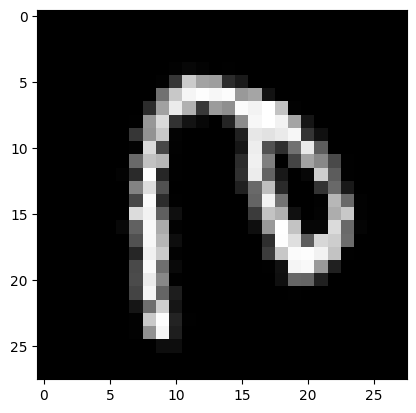

In [6]:
data = iter(img_loader)
image, target = next(data)
plt.imshow(image.squeeze(), cmap="gray")
plt.show()

In [18]:
def get_transforms(image, n_rotations=4, flips=True):
    """
    Returns all transformations of a single input image
    """
    transforms = [image]

    # Rotations
    for i in range(1, n_rotations):
        angle = i * (360 / n_rotations)
        rotated_image = TF.rotate(image, angle)
        transforms.append(rotated_image)

    # Flips
    if flips:
        flips = []
        for transform in transforms:
            flipped_image_lr = TF.hflip(transform)
            flips.append(flipped_image_lr)
        # for transform in transforms:
        #     flipped_image_ud = TF.vflip(transform)
        #     flips.append(flipped_image_ud)
        transforms.extend(flips)

    res = torch.cat(transforms)
    return res

def visualize_transforms(transformed_images):
    num_images = len(transformed_images)
    num_rows = (num_images - 1) // 4 + 1
    fig, axes = plt.subplots(num_rows, 4, figsize=(16, 4*num_rows))

    for i, img in enumerate(transformed_images):
        row = i // 4
        col = i % 4
        axes[row, col].imshow(img.permute(1, 2, 0), cmap="gray")  # Permute dimensions for visualization
        axes[row, col].axis('off')

    # Hide empty subplots
    for i in range(num_images, num_rows * 4):
        row = i // 4
        col = i % 4
        axes[row, col].axis('off')

    # Labeling axes
    for ax, col in zip(axes[0], ['Original', '90°', '180°', '270°']):
        ax.set_title(col, size="larger")

    plt.tight_layout()
    plt.show()

transformed_images = get_transforms(image)
visualize_transforms(transformed_images)

NameError: name 'image' is not defined

In [8]:
model.forward(image.to(device), output_cls=True).shape, model.forward(get_transforms(image.to(device)), output_cls=True).shape

(torch.Size([1, 64]), torch.Size([8, 64]))

#### Some possibilities of equivariant combination of the latent representations:
- Mean pooling
- Max pooling
- Sum
- Most probable
- Highest probability among transformations
- Learn weights for weighted average

In [9]:
from post_hoc_equivariant import *
from sub_models import ScoringModel, Transformer

#### First keeping the original model frozen

In [21]:
# baseline
evaluate(model)

100%|██████████| 16/16 [00:03<00:00,  4.80it/s]


97.55

In [23]:
# with average pooling
model = NormalMeanPool(model)
evaluate(model)

NameError: name 'NormalMeanPooling' is not defined

#### Equivariant Finetunning
 
Similar to the idea of Basu et al. (2023), which they proposed a finetuning method called equituning that starts with potentially non-equivariant model M and produces a model $M_G$ that is equivariant to a group G. 

Given a set $\chi$, group action of G on X is defined as $\Gamma X$: $G \times \chi$ -> $\chi$. We write $\Gamma X(g,x)$ simply as gx for bervity.

A model M: X -> Y is equivariant to G under the group action of G on X and Y if M(gx) = g(M(x)) for all g $\in$ G, x $\in$ $\chi$. This essentially means that any group transformation g to the input $\Gamma X(g,x)$ should reflect with an equivalent group transformation of the output  $\Gamma Y(g,M(x))$.

Equituning converts a pretrained model into an equivariant version by minimizing the distance of features obtained from pretrained and equivariant models. The output of an equituned model is given by

- $ x $ as the input image.
- $ g $ as a transformation in the group $ G $.
- $ g^{-1} $ as a inverse of the transformation in the group $ G $.
- $ M(x) $ as the output logits obtained from the original input image $ x $.
- $ M_G(x) $ as the output logits obtained from the transformed input image $ gx $.


$$ M_G(x) = \frac{\sum_{g \in G}{g^{-1}M(gx)}}{|G|} $$

In [12]:
# mean pooling
eq_model_mean = PostHocEquivariantMean(model, n_rotations=16, flips=False)
evaluate(eq_model_mean)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:39<00:00,  2.44s/it]


98.0

$$ M_G(x) = \max_{g \in G}{g^{-1}M(gx)}

In [13]:
# max pooling
eq_model_max = PostHocEquivariantMax(model, n_rotations=16, flips=False)
evaluate(eq_model_max)

100%|██████████| 16/16 [00:38<00:00,  2.43s/it]


97.8

$$ M_G(x) = \sum_{g \in G}{g^{-1}M(gx)}

In [ ]:
# summing latent dimensions
eq_model_sum = PostHocEquivariantSum(model, n_rotations=16, flips=False)
evaluate(eq_model_sum)

For the `PostHocEquivariantMostProbable` model, let's denote:
- $ x $ as the input image.
- $ g $ as a transformation in the group $ G $.
- $ M(x) $ as the output logits obtained from the original input image $ x $.
- $  M_G(x) $ as the output logits obtained from the transformed input image $ gx $.

The model computes logits for each transformation independently and then combines them to get the final logits. The equation can be represented as follows:

$$  M_G(x) = \log \left( \prod_{g \in G}\text{softmax}{(M(gx))} \right) $$


In [ ]:
# product of class probabilities
eq_model_most_probable = PostHocEquivariantMostProbable(model, n_rotations=16, flips=False)
evaluate(eq_model_most_probable)

For the `PostHocEquivariantMostCertain` model, let's denote:
- $ x $ as the input image.
- $ g $ as a transformation in the group $ G $.
- $ M(x) $ as the output logits obtained from the original input image $ x $.
- $ M_G(x) $ as the output logits obtained from the transformed input image $ gx $.

The model computes logits for each transformation independently and selects the transformation with the highest probability for each class. It then selects the logits corresponding to these highest probabilities. The equation can be represented as follows:

$$  M_G(x) =   \text{arg max}_{g \in G} (\text{softmax}{(M(gx)))} $$

In [ ]:
# take transformation with highest certainty for class
eq_model_most_certain = PostHocMostCertain(model, n_rotations=16, flips=False)
evaluate(eq_model_most_certain)

#### Learn weighs for weighted average

Also here there are a couple of options.
- a) nn takes as input entire latent dimension and outputs scalar representing weight for that dimensions
- b) nn takes as input the i'th entry of each latent dimension, the concatenation is a new latent dimension. Now we have to satisfy equivariance so this order of input should not matter. Use a transformer without PE in this case is a solution.


#### PostHocLearnedScoreAggregation
Similar to the idea of λ-equitune in (Sourya Basu (2023). Efficient Equivariant Transfer Learning from Pretrained Models), revolves around recognizing that, within a pretrained model M, features M(gx) derived from fixed x are not uniformly crucial across all transformations g $\in$ G. Let λ(gx) denote the significance weight assigned to feature M(gx) for g $\in$ G, x $\in$ X. Assuming a finite G, as in Basu et al. (2023), λ : X → $R^+$ is predefined. The λ-equituned model, denoted as $M^{λ} {G}$, aims to minimize:

$$\min_{ M_G^{λ}(x)} \sum_{g \in G} || λ(gx) M(gx) -  M_G^{λ}(g,x)||^{2}$$

subject to:

$$ M_G^{λ}(gx) = g M_G^{λ}(x)$$ 
for all g $\in$ G.

The solution to the above equation, referred to as λ-equitune, is given by:

$$ M_G^{λ}(x) = \frac{\sum_{g \in G}^{|G|}{g^{-1}λ(gx)M(gx)}}{\sum_{g \in G}{λ(gx)}}$$

In [15]:
# a)
set_seed(42)
scoring_model = ScoringModel()
eq_model_learned_score_aggregation = PostHocLearnedScoreAggregation(model=model, scoring_model=scoring_model)
eq_model_learned_score_aggregation = train(eq_model_learned_score_aggregation, train_loader, n_epochs=10)
evaluate(eq_model_learned_score_aggregation)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


Starting validaitons accuracy: 82.2


  0%|          | 0/10 [05:09<?, ?it/s]


KeyboardInterrupt: 

#### PostHocLearnedAggregation

This method aggregates the embeddings using the transformer and then passes the combined embeddings through the model's MLP head to get the final logits. Since the transformer operations (layer normalization, multi-head attention, and feed-forward networks) do not depend on the order of embeddings, the aggregated result is independent of the transformations applied to the input. The final logits are produced by passing the aggregated embeddings through the MLP head. This process is invariant to the transformations since it operates on the aggregated embeddings, which represent the transformed input space.


#### Mathematical Representation

   $$
   M_G(x) = \text{Mlp}(\text{Transformer}(M(gx))), g\in G
   $$

Since the aggregation model (transformer) is designed to handle sequences of embeddings in an order-invariant manner (due to the self-attention mechanism), the output should remain consistent under the same group transformations applied to the input and the output:

$$
 M_G(x) = g( M_G(x))
$$

Therefore, the `PostHocLearnedAggregation` model is equivariant by design because the transformer aggregation maintains the equivariance property through its self-attention mechanism and the consistent application of transformations across the input space. The use of the class token ensures that the final output logits are derived in a manner that respects the input transformations.


In [15]:
# b)
set_seed(42)
aggregation_model = Transformer(embed_dim=64, hidden_dim=128, num_heads=4, num_layers=2)
eq_model_learned_aggregation = PostHocLearnedAggregation(model=model, aggregation_model=aggregation_model)
eq_model_learned_aggregation.load_state_dict(torch.load('trained_LA_model.pt', map_location=torch.device('cpu')))

# eq_model_learned_aggregation = train(eq_model_learned_aggregation, train_loader, n_epochs=25)
evaluate(eq_model_learned_aggregation)

TypeError: Expected state_dict to be dict-like, got <class 'post_hoc_equivariant.PostHocLearnedAggregation'>.

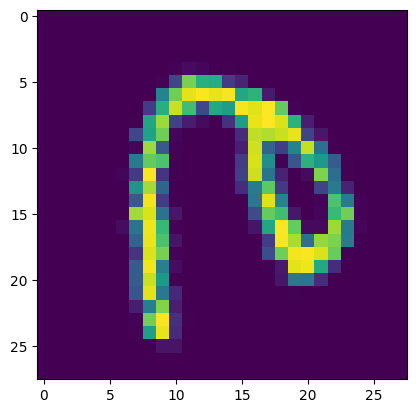

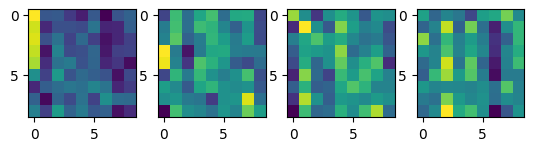

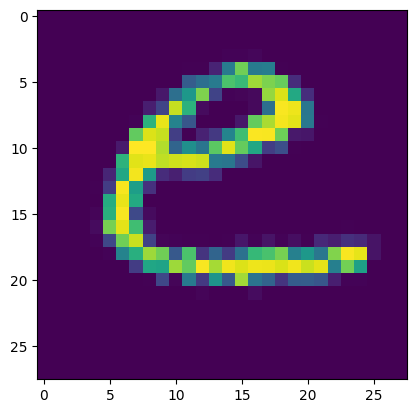

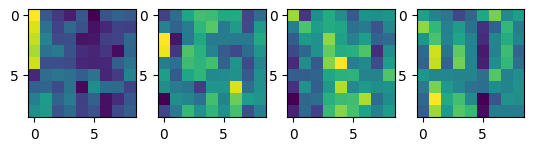

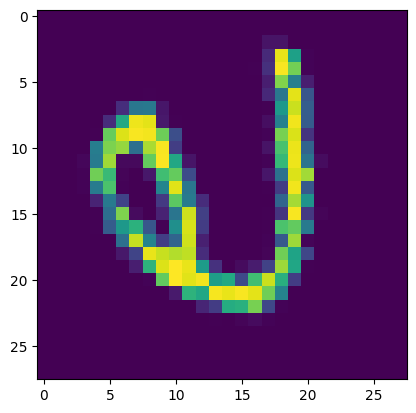

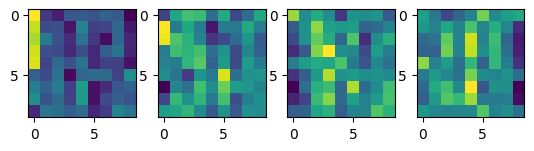

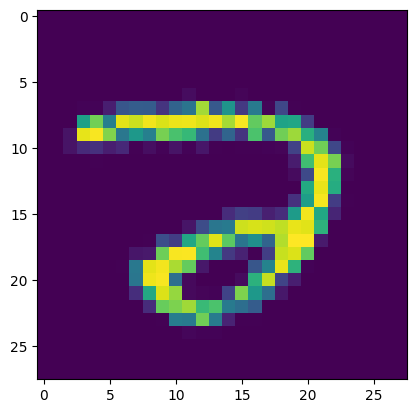

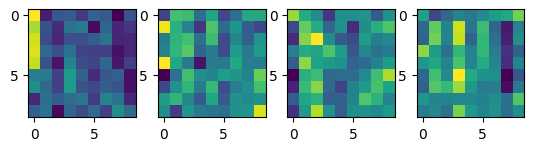

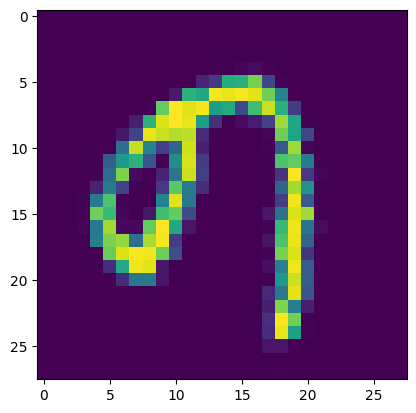

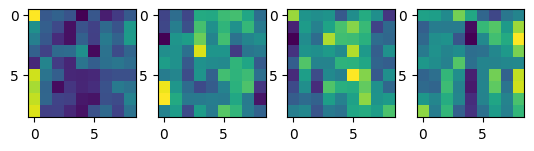

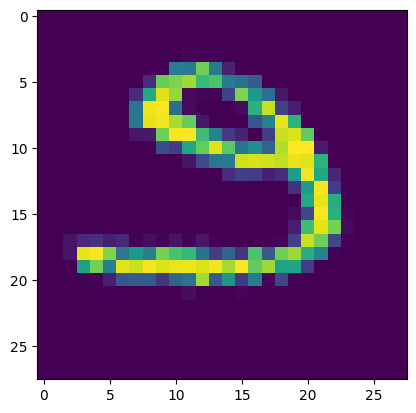

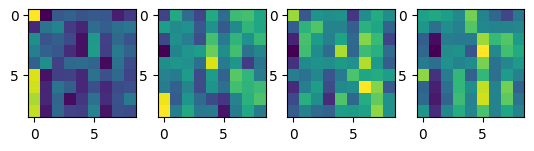

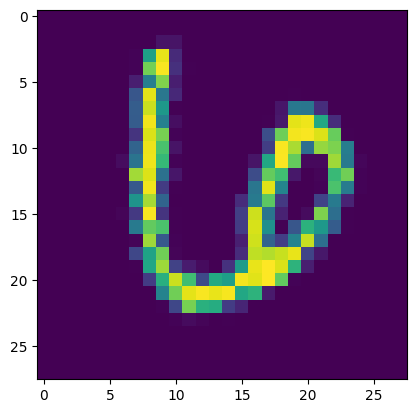

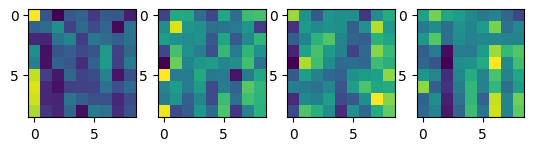

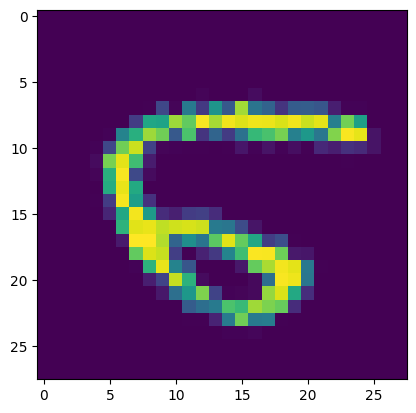

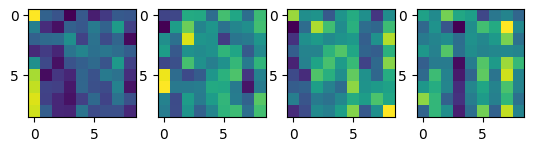

In [61]:
data = iter(img_loader)
image, target = next(data)

images = get_transforms(image)[0]
for img in images:
    out = eq_model_learned_aggregation.forward(img.unsqueeze(0).to(device), vis=True)

    plt.imshow(img[0])
    plt.show()

    for i in range(len(out)):
        plt.subplot(1, len(out), i+1)
        plt.imshow(out[i][0].detach().numpy())
    plt.show()

#### Now all options but with finetuning the mlp_head

In [ ]:
# mean pooling
set_seed(42)
model = get_non_equivariant_vit()
eq_model_mean = PostHocEquivariantMean(model, finetune_mlp_head=True)
eq_model_mean = train(eq_model_mean, n_epochs=25)
evaluate(eq_model_mean)

In [ ]:
# max pooling
set_seed(42)
model = get_non_equivariant_vit()
eq_model_max = PostHocEquivariantMax(model, finetune_mlp_head=True)
eq_model_max = train(eq_model_max, n_epochs=25)
evaluate(eq_model_max)

In [ ]:
# summing latent dimensions
set_seed(42)
model = get_non_equivariant_vit()
eq_model_sum = PostHocEquivariantSum(model, finetune_mlp_head=True)
eq_model_sum = train(eq_model_sum, n_epochs=25)
evaluate(eq_model_sum)

In [ ]:
# product of class probabilities
set_seed(42)
model = get_non_equivariant_vit()
eq_model_most_probable = PostHocEquivariantMostProbable(model, finetune_mlp_head=True)
eq_model_most_probable = train(eq_model_most_probable, n_epochs=25)
evaluate(eq_model_most_probable)

In [ ]:
# take transformation with highest certainty for class
set_seed(42)
model = get_non_equivariant_vit()
eq_model_most_certain = PostHocMostCertain(model, finetune_mlp_head=True)
eq_model_most_certain = train(eq_model_most_certain, n_epochs=25)
evaluate(eq_model_most_certain)

In [ ]:
# a)
set_seed(42)
model = get_non_equivariant_vit()
scoring_model = ScoringModel()
eq_model_learned_score_aggregation = PostHocLearnedScoreAggregation(model=model, scoring_model=scoring_model, finetune_mlp_head=True)
eq_model_learned_score_aggregation = train(eq_model_learned_score_aggregation, n_epochs=25)
evaluate(eq_model_learned_score_aggregation)

In [ ]:
# b)
set_seed(42)
aggregation_model = Transformer(embed_dim=64, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.1)
eq_model_learned_aggregation = PostHocLearnedAggregation(model=model, aggregation_model=aggregation_model, finetune_mlp_head=True)
# eq_model_learned_aggregation = train(eq_model_learned_aggregation, n_epochs=25)
evaluate(eq_model_learned_aggregation)

#### Now all options but finetuning the entire base model

In [ ]:
# mean pooling
set_seed(42)
model = get_non_equivariant_vit()
eq_model_mean = PostHocEquivariantMean(model, finetune_model=True)
eq_model_mean = train(eq_model_mean, n_epochs=25)
evaluate(eq_model_mean)

In [ ]:
# max pooling
set_seed(42)
model = get_non_equivariant_vit()
eq_model_max = PostHocEquivariantMax(model, finetune_model=True)
eq_model_max = train(eq_model_max, n_epochs=25)
evaluate(eq_model_max)

In [ ]:
# summing latent dimensions
set_seed(42)
model = get_non_equivariant_vit()
eq_model_sum = PostHocEquivariantSum(model, finetune_model=True)
eq_model_sum = train(eq_model_sum, n_epochs=25)
evaluate(eq_model_sum)

In [ ]:
# product of class probabilities
set_seed(42)
model = get_non_equivariant_vit()
eq_model_most_probable = PostHocEquivariantMostProbable(model, finetune_model=True)
eq_model_most_probable = train(eq_model_most_probable, n_epochs=25)
evaluate(eq_model_most_probable)

In [ ]:
# take transformation with highest certainty for class
set_seed(42)
model = get_non_equivariant_vit()
eq_model_most_certain = PostHocMostCertain(model, finetune_model=True)
eq_model_most_certain = train(eq_model_most_certain, n_epochs=25)
evaluate(eq_model_most_certain)

In [ ]:
# a)
set_seed(42)
model = get_non_equivariant_vit()
scoring_model = ScoringModel()
eq_model_learned_score_aggregation = PostHocLearnedScoreAggregation(model=model, scoring_model=scoring_model, finetune_model=True)
eq_model_learned_score_aggregation = train(eq_model_learned_score_aggregation, n_epochs=25)
evaluate(eq_model_learned_score_aggregation)

In [ ]:
# b)
set_seed(42)
aggregation_model = Transformer(embed_dim=64, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.1)
eq_model_learned_aggregation = PostHocLearnedAggregation(model=model, aggregation_model=aggregation_model, finetune_model=True)
veq_model_learned_aggregation = train(eq_model_learned_aggregation, n_epochs=25)
evaluate(eq_model_learned_aggregation)